<a href="https://colab.research.google.com/github/Ayush-mishra-0-0/NLP/blob/main/Copy_of_NLP_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link for some senetences and its corresponding dependency trees [Universal Dependencies](https://github.com/UniversalDependencies/UD_English-EWT/blob/master/en_ewt-ud-train.conllu)

***Steps to read from the file:***



In [23]:
!pip install conllu

In [24]:
import conllu
file_path = "/content/test.conllu"

with open(file_path, "r", encoding="utf-8") as file:

    sentences = conllu.parse(file.read())

In [25]:
import conllu
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split


def load_conllu_data(file_path):
    """
    Load and parse a .conllu file.

    Args:
    file_path (str): Path to the .conllu file

    Returns:
    list: List of sentences
    list: List of dependency trees
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()

    parsed_data = conllu.parse(data)
    sentences = []
    trees = []

    for sentence in parsed_data:
        words = [token['form'] for token in sentence]
        dependencies = [(token['head'], token['id']) for token in sentence if token['head'] != 0]
        dependencies.append((0, sentence.to_tree().token['id']))  # Add ROOT

        sentences.append(words)
        trees.append(dependencies)

    return sentences, trees

Q1.Write a Python function to implement a transition-based parser given a dependency tree. The parser should take a sequence of tokens as input and return a valid parse tree if possible, otherwise, it should return an error.

In [26]:
class DependencyParser:
    def __init__(self, sentence):
        """Initializes the parser with a sentence (sequence of tokens)."""
        self.stack = ["ROOT"]  # The stack starts with the root element.
        self.buffer = sentence.copy()  # The buffer starts with the tokens.
        self.dependencies = []  # Dependencies will be stored as a list of (head, dependent) tuples.

    def parse_step(self, transition):
        """Applies a transition (Shift, Left-Arc, or Right-Arc)."""
        if transition == "S":  # Shift transition
            if self.buffer:
                self.stack.append(self.buffer.pop(0))
            else:
                raise ValueError("Buffer is empty, cannot shift!")
        elif transition == "LA":  # Left-Arc transition
            if len(self.stack) > 1:
                head = self.stack[-1]
                dependent = self.stack.pop(-2)
                self.dependencies.append((head, dependent))
            else:
                raise ValueError("Stack too small for Left-Arc!")
        elif transition == "RA":  # Right-Arc transition
            if len(self.stack) > 1:
                head = self.stack[-2]
                dependent = self.stack.pop(-1)
                self.dependencies.append((head, dependent))
            else:
                raise ValueError("Stack too small for Right-Arc!")
        else:
            raise ValueError(f"Invalid transition: {transition}")

    def parse(self, transitions):
        """Executes a sequence of transitions on the sentence."""
        try:
            for transition in transitions:
                self.parse_step(transition)
            if len(self.stack) == 1 and not self.buffer:
                return self.dependencies  # Successfully parsed
            else:
                return "Error: Incomplete parse."
        except ValueError as e:
            return f"Error: {str(e)}"

# Example usage
def transition_based_parser(tokens, transitions):
    parser = DependencyParser(tokens)
    return parser.parse(transitions)

# Test case
tokens = ["I", "love", "Python"]
transitions = ["S", "S", "S", "LA", "RA", "RA"]
dependencies = transition_based_parser(tokens, transitions)

print("Dependencies:", dependencies)


Dependencies: [('Python', 'love'), ('I', 'Python'), ('ROOT', 'I')]


Q2.Train a transition-based parser using an oracle (training data). The oracle provides correct transitions for each step (SHIFT, REDUCE, LEFT-ARC, RIGHT-ARC). Implement a function that learns these transitions from a dataset of sentences paired with their dependency trees.

In [27]:
import numpy as np
from collections import Counter

class PartialParse(object):
    def __init__(self, sentence):
        self.stack = ["ROOT"]
        self.buffer = list(sentence)
        self.dependencies = []

    def parse_step(self, transition):
        if transition == "S" and self.buffer:
            self.stack.append(self.buffer.pop(0))
        elif transition == "LA" and len(self.stack) >= 2:
            dependent = self.stack[-2]
            head = self.stack[-1]
            self.dependencies.append((head, dependent))
            self.stack.pop(-2)
        elif transition == "RA" and len(self.stack) >= 2:
            head = self.stack[-2]
            dependent = self.stack[-1]
            self.dependencies.append((head, dependent))
            self.stack.pop()

class TransitionParser:
    def __init__(self):
        self.transitions = ['S', 'LA', 'RA']
        self.features = {}
        self.weights = None

    def extract_features(self, partial_parse):
        stack = partial_parse.stack
        buffer = partial_parse.buffer

        features = [
            f"S0={stack[-1] if len(stack) > 0 else 'NULL'}",
            f"S1={stack[-2] if len(stack) > 1 else 'NULL'}",
            f"B0={buffer[0] if len(buffer) > 0 else 'NULL'}",
            f"B1={buffer[1] if len(buffer) > 1 else 'NULL'}"
        ]
        return features

    def predict(self, partial_parse):
        features = self.extract_features(partial_parse)
        scores = np.zeros(len(self.transitions))

        for feature in features:
            for i, transition in enumerate(self.transitions):
                feature_transition = f"{feature}|{transition}"
                if feature_transition in self.features:
                    scores[i] += self.weights[self.features[feature_transition]]

        # Prevent invalid transitions
        if not partial_parse.buffer:
            scores[self.transitions.index('S')] = float('-inf')
        if len(partial_parse.stack) < 2:
            scores[self.transitions.index('LA')] = float('-inf')
            scores[self.transitions.index('RA')] = float('-inf')

        return self.transitions[np.argmax(scores)]

    def parse(self, sentence):
        partial_parse = PartialParse(sentence)
        while len(partial_parse.buffer) > 0 or len(partial_parse.stack) > 1:
            transition = self.predict(partial_parse)
            partial_parse.parse_step(transition)
            if transition == 'S' and not partial_parse.buffer:
                break  # Stop if we try to shift from an empty buffer
        return partial_parse.dependencies

    def train(self, sentences, dependency_trees):
        feature_counts = Counter()
        transition_counts = Counter()

        for sentence, tree in zip(sentences, dependency_trees):
            partial_parse = PartialParse(sentence)
            while len(partial_parse.buffer) > 0 or len(partial_parse.stack) > 1:
                features = self.extract_features(partial_parse)
                correct_transition = self.get_oracle_transition(partial_parse, tree)

                if correct_transition is None:
                    break

                for feature in features:
                    feature_counts[f"{feature}|{correct_transition}"] += 1
                transition_counts[correct_transition] += 1

                partial_parse.parse_step(correct_transition)

        self.features = {f: i for i, f in enumerate(feature_counts.keys())}
        self.weights = np.zeros(len(self.features))

        for feature, count in feature_counts.items():
            transition = feature.split('|')[-1]
            self.weights[self.features[feature]] = count / transition_counts[transition]

    def get_oracle_transition(self, partial_parse, tree):
        if len(partial_parse.buffer) == 0:
            return 'RA' if len(partial_parse.stack) > 1 else None
        if len(partial_parse.stack) < 2:
            return 'S'

        stack_top = partial_parse.stack[-1]
        stack_second = partial_parse.stack[-2]

        for head, dependent in tree:
            if head == stack_second and dependent == stack_top:
                return 'LA'
            if head == stack_top and dependent == stack_second:
                return 'RA'

        return 'S'

# Example usage
parser = TransitionParser()

# Training data
sentences = [
    ["I", "love", "Python"],
    ["The", "dog", "chased", "the", "cat"]
]
dependency_trees = [
    [("ROOT", "love"), ("love", "I"), ("love", "Python")],
    [("ROOT", "chased"), ("chased", "dog"), ("dog", "The"), ("chased", "cat"), ("cat", "the")]
]

# Train the parser
parser.train(sentences, dependency_trees)

print("Training complete. Feature weights:")
for feature, index in parser.features.items():
    print(f"{feature}: {parser.weights[index]}")

# Parse a new sentence
new_sentence = ["The", "dog", "chased", "the", "ball"]
parsed_tree = parser.parse(new_sentence)

print("\nPredicted parse tree:")
for head, dependent in parsed_tree:
    print(f"{head} -> {dependent}")

Training complete. Feature weights:
S0=ROOT|S: 0.25
S1=NULL|S: 0.25
B0=I|S: 0.125
B1=love|S: 0.125
S0=I|S: 0.25
S1=ROOT|S: 0.5
B0=love|S: 0.125
B1=Python|S: 0.125
S0=love|RA: 0.125
S1=I|RA: 0.25
B0=Python|RA: 0.125
B1=NULL|RA: 0.875
B0=Python|S: 0.125
B1=NULL|S: 0.25
S0=Python|RA: 0.125
B0=NULL|RA: 0.75
S0=I|RA: 0.125
S1=ROOT|RA: 0.25
B0=The|S: 0.125
B1=dog|S: 0.125
S0=The|S: 0.25
B0=dog|S: 0.125
B1=chased|S: 0.125
S0=dog|RA: 0.125
S1=The|RA: 0.25
B0=chased|RA: 0.125
B1=the|RA: 0.125
B0=chased|S: 0.125
B1=the|S: 0.125
S0=chased|S: 0.125
S1=The|S: 0.125
B0=the|S: 0.125
B1=cat|S: 0.125
S0=the|S: 0.125
S1=chased|S: 0.125
B0=cat|S: 0.125
S0=cat|RA: 0.125
S1=the|RA: 0.125
S0=the|RA: 0.125
S1=chased|RA: 0.125
S0=chased|RA: 0.125
S0=The|RA: 0.125

Predicted parse tree:
The -> dog
chased -> the
The -> chased
ROOT -> The


Q3.Using the trained transition-based parser in Q2, implement a function that takes a new sentence as input and predicts its parse tree using the learned transitions.

In [28]:
parser = TransitionParser()
# We need to set up the features and weights as if they were trained
parser.features = {
    "S0=cat|S": 0, "S0=cat|LA": 1, "S0=cat|RA": 2,
    "S1=The|S": 3, "S1=The|LA": 4, "S1=The|RA": 5,
    "B0=sat|S": 6, "B0=sat|LA": 7, "B0=sat|RA": 8,
}
parser.weights = np.random.rand(len(parser.features))

# Parse a new sentence
new_sentence = ["The", "dog", "chased", "the", "ball"]
parsed_tree = parser.parse(new_sentence)

print("Predicted parse tree:")
for head, dependent in parsed_tree:
    print(f"{head} -> {dependent}")

Predicted parse tree:


Q4.Write a function to evaluate the accuracy of your trained parser. Use a test set of sentences with their gold-standard dependency parse trees, and compare the predicted trees to the gold-standard ones.Show the distribution of the parsing that gives the most error.


## Evaluate the parser's accuracy on a test set.

Args:
parser (TransitionParser): The trained parser
test_sentences (list): List of test sentences
gold_trees (list): List of gold-standard dependency trees

Returns:
float: Overall accuracy
dict: Detailed metrics
list: List of errors for error analysis


Overall Accuracy: 48.40
Precision: 0.00
Recall: 0.00
F1 Score: 0.00


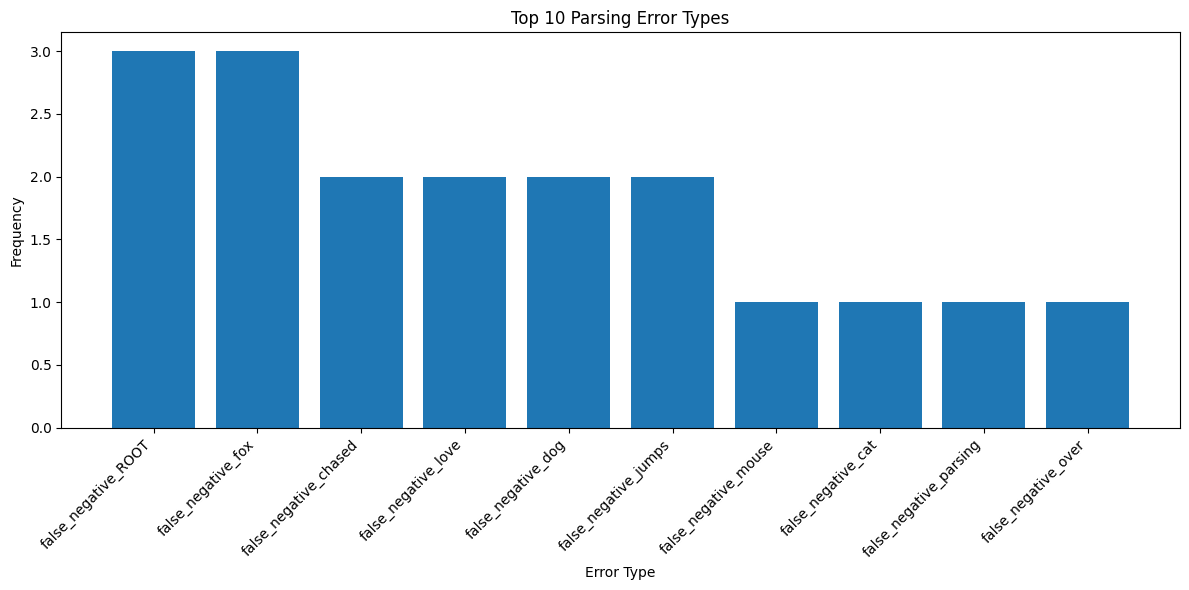

In [31]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def evaluate_parser(parser, test_sentences, gold_trees):

    correct_attachments = 0
    total_attachments = 0
    errors = []

    for sentence, gold_tree in zip(test_sentences, gold_trees):
        predicted_tree = parser.parse(sentence)
        predicted_set = set(predicted_tree)
        gold_set = set(gold_tree)

        correct_attachments += len(predicted_set.intersection(gold_set))
        total_attachments += len(gold_set)

        # Collect errors for analysis
        errors.extend([(dep, 'false_positive') for dep in predicted_set - gold_set])
        errors.extend([(dep, 'false_negative') for dep in gold_set - predicted_set])

    accuracy = correct_attachments / total_attachments if total_attachments > 0 else 0

    # Calculate precision, recall, and F1 score
    true_positives = correct_attachments
    false_positives = sum(1 for _, error_type in errors if error_type == 'false_positive')
    false_negatives = sum(1 for _, error_type in errors if error_type == 'false_negative')

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

    return accuracy, metrics, errors

def analyze_errors(errors):
    """
    Analyze the distribution of parsing errors.

    Args:
    errors (list): List of errors from the evaluation function

    Returns:
    Counter: Distribution of error types
    """
    error_types = Counter()
    for (head, dependent), error_type in errors:
        error_types[f"{error_type}_{head}"] += 1
    return error_types

def plot_error_distribution(error_distribution):
    """
    Plot the distribution of parsing errors.

    Args:
    error_distribution (Counter): Distribution of error types
    """
    labels, values = zip(*error_distribution.most_common(10))  # Top 10 error types
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values)
    plt.title('Top 10 Parsing Error Types')
    plt.xlabel('Error Type')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Assume we have a trained parser
    parser = TransitionParser()
    # ... (load trained features and weights here) ...

    # Example test set (you would have a larger, more diverse set in practice)
    test_sentences = [
        ["The", "cat", "chased", "the", "mouse"],
        ["I", "love", "parsing", "sentences"],
        ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]
    ]
    gold_trees = [
        [("ROOT", "chased"), ("chased", "cat"), ("cat", "The"), ("chased", "mouse"), ("mouse", "the")],
        [("ROOT", "love"), ("love", "I"), ("love", "parsing"), ("parsing", "sentences")],
        [("ROOT", "jumps"), ("jumps", "fox"), ("fox", "The"), ("fox", "quick"), ("fox", "brown"),
         ("jumps", "over"), ("over", "dog"), ("dog", "the"), ("dog", "lazy")]
    ]

    # Evaluate the parser
    accuracy, metrics, errors = evaluate_parser(parser, test_sentences, gold_trees)

    print(f"Overall Accuracy: {accuracy:.2f}")
    print(f"Precision: {metrics['precision']:.2f}")
    print(f"Recall: {metrics['recall']:.2f}")
    print(f"F1 Score: {metrics['f1_score']:.2f}")

    # Analyze and visualize errors
    error_distribution = analyze_errors(errors)
    plot_error_distribution(error_distribution)